Incomplete (revisited) implementation of CHOWDER method as described in https://arxiv.org/pdf/1802.02212.pdf

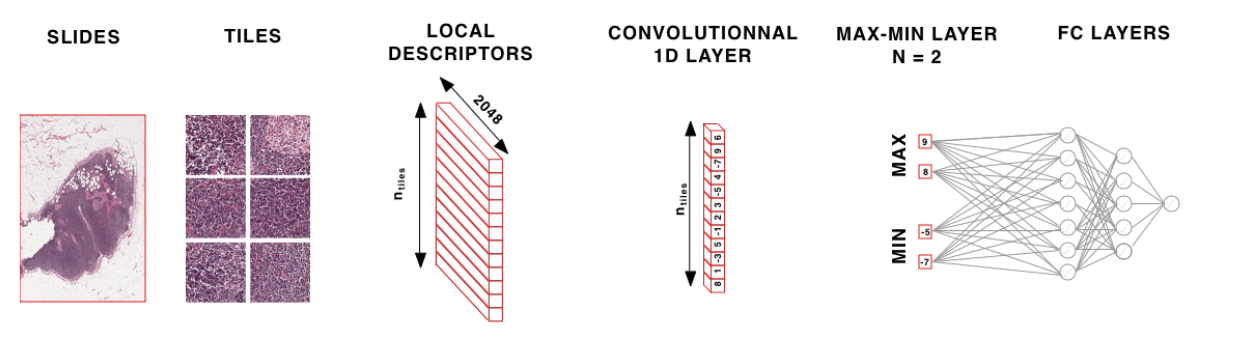

**The authors in the paper use far more than 20 tiles**.
Hope it'll provides some ideas for the challenge

I've used a similar training framework that https://www.kaggle.com/yasufuminakama/panda-se-resnext50-classification-baseline + iafoss tiling method https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-0-79-lb

# Libraries

In [ ]:
import os
import gc
import random
import sys
import time
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import skimage.io
import cv2
import PIL
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Resize, \
RandomRotate90, OneOf, RandomContrast, RandomGamma, RandomBrightness, ShiftScaleRotate, \
Equalize
import torch
from skimage.transform import AffineTransform, warp
import warnings
warnings.filterwarnings("ignore")
import torchvision
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score
import seaborn as sn
from functools import partial

# Install pre-trained models
sys.path.insert(0, '../input/pytorch-pretrained-models/semi-supervised-ImageNet1K-models-master/semi-supervised-ImageNet1K-models-master/')
from hubconf import *

#Define paths
BASE_PATH = '/kaggle/input'
TRAIN_IMG_DIR = f'{BASE_PATH}/panda-128x128x20/kaggle/train_images/'
train = pd.read_csv(f'{BASE_PATH}/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

# Global variables
MODEL_NAME = 'resnext50_32x4d_ssl' 

LOSS = 'CE' 

# Config

In [ ]:
class CFG:
    debug=False
    lr=1e-3
    batch_size=16
    epochs=8
    onecyclepolicy=False
    seed=35
    n_fold=4
    
class CFG_MODEL:
    ntiles = 20
    sztiles = 128
    szbag = 2
    target_size = 6 
    target_col = 'isup_grade'

In [ ]:
files = sorted(set([p[:32] for p in os.listdir(TRAIN_IMG_DIR)]))
train = train.loc[files]
train = train.reset_index()
print(len(train))

# Utils

In [ ]:
def seed_everything(seed=99):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)
    
# Fastai layers (https://github.com/alecrubin/pytorch-serverless/blob/master/fastai/layers.py)
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


class Lambda(nn.Module):
    def __init__(self, f): super().__init__(); self.f = f
    def forward(self, x): return self.f(x)


class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)
    
    
# Label smoothing
# https://www.kaggle.com/vladvdv/pytorch-training-customizable-kernel-with-5-folds
def onehot_encoding(label, n_classes):
    return torch.zeros(label.size(0), n_classes).to(label.device).scatter_(
        1, label.view(-1, 1), 1)
def cross_entropy_loss(input, target, reduction):
    logp = F.log_softmax(input, dim=1)
    loss = torch.sum(-logp * target, dim=1)
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(
            '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')
        
def label_smoothing_criterion(epsilon=0.1, reduction='mean'):
    def _label_smoothing_criterion(preds, targets):
        n_classes = preds.size(1)
        device = preds.device

        onehot = onehot_encoding(targets, n_classes).float().to(device)
        targets = onehot * (1 - epsilon) + torch.ones_like(onehot).to(
            device) * epsilon / n_classes
        loss = cross_entropy_loss(preds, targets, reduction)
        if reduction == 'none':
            return loss
        elif reduction == 'mean':
            return loss.mean()
        elif reduction == 'sum':
            return loss.sum()
        else:
            raise ValueError(
                '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

    return _label_smoothing_criterion

# Dataset

In [ ]:
class PandaDatasetInt:
    def __init__(self, df, N, sz, transform=None):
        self.image_ids=df.image_id.values
        self.isup_grade = df.isup_grade.values
        self.data_provider = df.data_provider.values
        self.transform=transform
        self.df=df
        self.tile_sz = sz
        self.tile_nb = N
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        fn_base = f'{TRAIN_IMG_DIR}{self.image_ids[index]}'
        img = PIL.Image.open(f"{fn_base}.png").convert('RGB')
        img = np.array(img)
        img = img.reshape(img.shape[0] // self.tile_sz, self.tile_sz, img.shape[1] // self.tile_sz, self.tile_sz, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, self.tile_sz, self.tile_sz, 3)  # Nxszxszx3
        img = img.astype(np.single)
        
        if self.transform:
            for i in range(self.tile_nb):
                aug = self.transform(image=img[i])
                img[i] = aug['image'].permute(1,2,0)
                
        label = self.isup_grade[index]
        provider = self.data_provider[index]
        return  torch.tensor(img.transpose(0, 3, 1, 2)), torch.tensor(label), provider

# Visualize

In [ ]:
# Display batch
tfm = Compose([
        ToTensorV2(),
    ])

dataset = PandaDatasetInt(train, N=CFG_MODEL.ntiles, sz=CFG_MODEL.sztiles, transform=tfm)
loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

images, label, provider = next(iter(loader))
for i in range(8):
    grid = torchvision.utils.make_grid(images[i].int(), nrow=20)
    plt.figure(figsize=(30,30))
    plt.imshow(grid.permute(1,2,0))
    plt.title(f'isup grade = {label[i].item()} | provider : {provider[i]}')

# Training

In [ ]:
# RESNEXT
def _resnext(block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model

class Model(nn.Module):
    def __init__(self, n=6, N=12, R=2):
        super().__init__()
        self.R = R
        m = _resnext(Bottleneck, [3, 4, 6, 3], False, progress=False, groups=32, width_per_group=4)
        m.load_state_dict(torch.load('../input/pytorch-pretrained-models/semi_supervised_resnext50_32x4-ddb3e555.pth'))
        
        self.backbone = nn.Sequential(*list(m.children())[:-1]) 
        nc = list(m.children())[-1].in_features
        self.conv1d = nn.Conv1d(N, N, nc)
        self.head =  nn.Sequential(
            Flatten(), 
            nn.Linear(R*2,200), nn.ReLU(), nn.BatchNorm1d(200), nn.Dropout(0.5), 
            nn.Linear(200,100), nn.ReLU(), nn.BatchNorm1d(100), nn.Dropout(0.5),                            
            nn.Linear(100, n))

    def forward(self, x):
        shape = x.shape
        n = shape[1]
        x = x.view(-1, shape[2],shape[3],shape[4]) #x: bs*N x C x 128 x 128
        # Backbone
        x = self.backbone(x) # => x: bs*N x C x 1 x 1
        x = x.view(-1, n, x.shape[1], x.shape[2], x.shape[3]) # => x: bs x N x C x 1 x 1
        x = x.view(x.shape[0], x.shape[1], -1) # => x: bs x N x C
        x = self.conv1d(x)  # => x: bs x N 
        x, _ = torch.sort(x, dim=1, descending=True)
        x = torch.cat((x[:, :(self.R)], x[:, (n - self.R):]), 1)  # keep min and max
        x = self.head(x) # => x: bs x 6
        return x

# Split train/val

In [ ]:
if CFG.debug:
    folds = train.sample(n=50, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train.copy()

train_labels = folds[CFG_MODEL.target_col].values
kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

# Train 

In [ ]:
def train_fn(fold):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"### fold: {fold} ###")
    
    lossTrain = []
    stepTrain = []
    lossVal = []
    stepVal = []
    
    step = 0
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    # Transforms
    transformTrain = Compose([
        OneOf([RandomBrightness(limit=0.15), RandomContrast(limit=0.3), RandomGamma()], p=0.25),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.3),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

    transformValid = Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
                        
    # Data loaders
    train_dataset = PandaDatasetInt(folds.loc[trn_idx].reset_index(drop=True), N=20, sz=128, transform=transformTrain)
    valid_dataset = PandaDatasetInt(folds.loc[val_idx].reset_index(drop=True), N=20, sz=128, transform=transformValid)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, num_workers=4)
    
    # Model
    model = Model(n=CFG_MODEL.target_size, N=CFG_MODEL.ntiles, R=CFG_MODEL.szbag)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    if CFG.onecyclepolicy == True:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, div_factor=100, pct_start=0.0, steps_per_epoch=len(train_loader), epochs=CFG.epochs)
    else:
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    
    if LOSS == 'CE':
        criterion = nn.CrossEntropyLoss()
    elif LOSS == 'LabelSmoothingCE':
        criterion = label_smoothing_criterion()
        
    best_score = -100
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        start_time = time.time()

        model.train()
        avg_loss = 0.

        optimizer.zero_grad()
        tk0 = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels, _) in tk0:

            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            lossTrain.append(loss.item())
            stepTrain.append(step)
            
            if CFG.onecyclepolicy == True:
                scheduler.step()

            avg_loss += loss.item() / len(train_loader)
            step += 1
            
        model.eval()
        avg_val_loss = 0.
        preds = []
        valid_labels = []
        tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

        for i, (images, labels, _) in tk1:
            
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                y_preds = model(images)
            
            preds.append(y_preds.to('cpu').numpy().argmax(1))
            valid_labels.append(labels.to('cpu').numpy())

            loss = criterion(y_preds, labels)
            avg_val_loss += loss.item() / len(valid_loader)
            
        lossVal.append(avg_val_loss)
        stepVal.append(step)
            
        if CFG.onecyclepolicy == False:
            scheduler.step(avg_val_loss)
            
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        
        LOGGER.debug(f'Counter preds: {Counter(preds)}')
        score = cohen_kappa_score(valid_labels, preds, weights='quadratic')
        
        if epoch == (CFG.epochs - 1):
            print(confusion_matrix(valid_labels, preds))

        elapsed = time.time() - start_time
        
        LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch+1} - QWK: {score}')
        
        if score>best_score:
            best_score = score
            LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(), f'fold{fold}_se_resnext50.pth')
            
    # Plot losses 
    plt.figure(figsize=(26,6))
    plt.subplot(1, 2, 1)
    plt.plot(stepTrain, lossTrain, label="training loss")
    plt.plot(stepVal, lossVal, label = "validation loss")
    plt.title('Loss')
    plt.xlabel('step')
    plt.legend(loc='center left')
    plt.tight_layout()
    plt.show()

In [ ]:
#for fold in range(CFG.n_fold):
train_fn(1)